# Titanic Survivor 
### Binary Classification 

Kaggle provides a test and a train dataset. The training data provides a Survived column which shows a 1 if the passenger survived and a 0 if they did not. This is ultimately the feature we are trying to predict.

In [1]:
# use the Azure Machine Learning data source package
from azureml.dataprep import datasource

# classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation

# modules to handle data
import pandas as pd
import numpy as np

# matplotlib for plotting and visualization
import matplotlib.pyplot as plt 
# seaborn for data visualization
import seaborn as sns   

from statsmodels.nonparametric.kde import KDEUnivariate

from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

C:\Users\Priyanka\AppData\local\AmlWorkbench\Python\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### I. Data Wrangling and Preprocessing

In [2]:
# load data 
train = datasource.load_datasource('train.dsource')
test = datasource.load_datasource('test.dsource')

# combining the datasets to work on them simultaneaously 
full_data = [train, test]

In [3]:
# glimpse of the data
full_data[0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,,S
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,,S
3,4.0,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
4,5.0,0.0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,,S


##### Looking for missing data

In [4]:
for df in full_data:
    print(df.count())

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          891
Embarked       891
dtype: int64
PassengerId    418
Pclass         418
Name           418
Sex            418
Age            332
SibSp          418
Parch          418
Ticket         418
Fare           417
Cabin          418
Embarked       418
dtype: int64


From the counts it is clear that there are missing entries for the Age feature in both datasets, and 1 missing entry for the Fare feature in the Test dataset.

To fill the missing age estimates, I first created a Title feature which simply extracts the honorific from the Name feature. Simply put, an honorific is the title or rank of a given person such as “Mrs” or “Miss”. The following code takes a value like “Braund, Mr. Owen Harris” from the Name column and extracts “Mr”:

In [5]:
# create a new feature to extract title names from the Name column
for df in full_data:
    df['Title'] = df.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,,S,Mr
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,Mrs
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,,S,Miss
3,4.0,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,Mrs
4,5.0,0.0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,,S,Mr


In [187]:
for df in full_data:
    print(df.Title.unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


In [7]:
print (train[['Title', 'Survived', 'Sex']].groupby(['Title', 'Sex'], as_index=False).mean())

           Title     Sex  Survived
0           Capt    male  0.000000
1            Col    male  0.500000
2            Don    male  0.000000
3             Dr  female  1.000000
4             Dr    male  0.333333
5       Jonkheer    male  0.000000
6           Lady  female  1.000000
7          Major    male  0.500000
8         Master    male  0.575000
9           Miss  female  0.697802
10          Mlle  female  1.000000
11           Mme  female  1.000000
12            Mr    male  0.156673
13           Mrs  female  0.792000
14            Ms  female  1.000000
15           Rev    male  0.000000
16           Sir    male  1.000000
17  the Countess  female  1.000000


In [8]:
print (train[['Title', 'Sex', 'Survived']].groupby(['Title', 'Sex'], as_index=False).count())

           Title     Sex  Survived
0           Capt    male         1
1            Col    male         2
2            Don    male         1
3             Dr  female         1
4             Dr    male         6
5       Jonkheer    male         1
6           Lady  female         1
7          Major    male         2
8         Master    male        40
9           Miss  female       182
10          Mlle  female         2
11           Mme  female         1
12            Mr    male       517
13           Mrs  female       125
14            Ms  female         1
15           Rev    male         6
16           Sir    male         1
17  the Countess  female         1


After viewing the unique Titles that were pulled, we see that we have 18 different titles but we will want to normalize these a bit so that we can generalize a bit more. To do this, we will create a dictionary that maps the 18 titles to 5 broader categories and then map that dictionary back to the Title feature.

In [9]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess','Capt', 'Col',\
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


This can now be used to estimate the missing ages just a little bit better. The next step is to estimate the missing Age values. To do this, we will group the dataset by Sex, Pclass (Passenger Class), and Title.

Instead of simply filling in the missing Age values with the mean or median age of the dataset, by grouping the data by a passenger’s sex, class, and title, we can drill down a bit deeper and get a closer approximation of what a passenger’s age might have been. Using the grouped.Age variable, we can fill in the missing values for Age.

Alternate: Linear Regression on Age

In [10]:
# group by Sex, Pclass, and Title and view the median Age by the grouped features
for df in full_data:
    grouped = df.groupby(['Sex','Pclass', 'Title'])
    df.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))
    print(grouped.Age.median())

Sex     Pclass  Title 
female  1.0     Miss      30.0
                Mrs       40.0
                Rare      48.0
        2.0     Miss      24.0
                Mrs       32.0
        3.0     Miss      18.0
                Mrs       31.0
male    1.0     Master     4.0
                Mr        40.0
                Rare      49.0
        2.0     Master     1.0
                Mr        31.0
                Rare      46.5
        3.0     Master     4.0
                Mr        26.0
Name: Age, dtype: float64
Sex     Pclass  Title 
female  1.0     Miss      32.0
                Mrs       48.0
                Rare      39.0
        2.0     Miss      19.5
                Mrs       29.0
        3.0     Miss      22.0
                Mrs       28.0
male    1.0     Master     9.5
                Mr        42.0
                Rare      53.0
        2.0     Master     5.0
                Mr        28.0
                Rare      35.5
        3.0     Master     7.0
                Mr        25.

We move on the next feature that is missing: Fare

In [11]:
# fill NaN with median fare
test.Fare = test.Fare.fillna(test.Fare.median())

Reviewing the count

In [12]:
for df in full_data:
    print(df.count())

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            891
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          891
Embarked       891
Title          891
dtype: int64
PassengerId    418
Pclass         418
Name           418
Sex            418
Age            418
SibSp          418
Parch          418
Ticket         418
Fare           418
Cabin          418
Embarked       418
Title          418
dtype: int64


##### Visualizing data

In [194]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

# lets us plot many diffrent shaped graphs together 
ax1 = plt.subplot2grid((2,3),(0,0))
# plots a bar graph of those who surived vs those who did not.               
train.Survived.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
# this nicely sets the margins in matplotlib to deal with a recent bug 1.3.1
ax1.set_xlim(-1, 2)
# puts a title on our graph
plt.title("Distribution of Survival, (1 = Survived)")    

plt.subplot2grid((2,3),(0,1))
plt.scatter(train.Survived, train.Age, alpha=alpha_scatterplot)
# sets the y axis lable
plt.ylabel("Age")
# formats the grid line style of our graphs                          
plt.grid(b=True, which='major', axis='y')  
plt.title("Survival by Age,  (1 = Survived)")

ax3 = plt.subplot2grid((2,3),(0,2))
train.Pclass.value_counts().plot(kind="barh", alpha=alpha_bar_chart)
ax3.set_ylim(-1, len(df.Pclass.value_counts()))
plt.title("Class Distribution")

plt.subplot2grid((2,3),(1,0), colspan=2)
# plots a kernel density estimate of the subset of the 1st class passangers's age
train.Age[train.Pclass == 1].plot(kind='kde')    
train.Age[train.Pclass == 2].plot(kind='kde')
train.Age[train.Pclass == 3].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') 

ax5 = plt.subplot2grid((2,3),(1,2))
train.Embarked.value_counts().plot(kind='bar', alpha=alpha_bar_chart)
ax5.set_xlim(-1, len(train.Embarked.value_counts()))
# specifies the parameters of our graphs
plt.title("Passengers per boarding location")

Text(0.5,1,'Passengers per boarding location')

##### Correlation Matrix

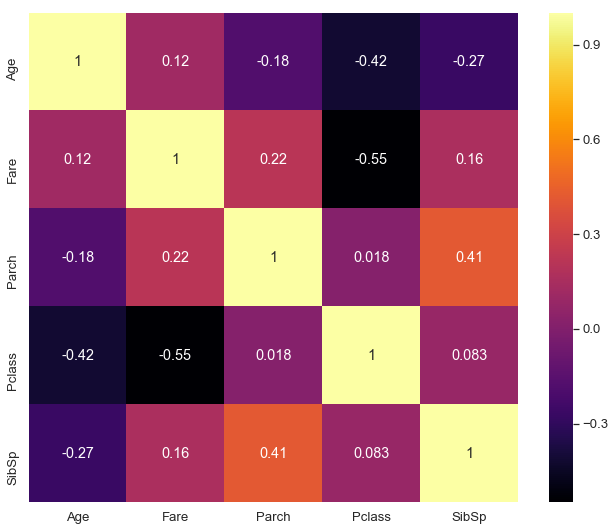

In [108]:
# set seaborn parameters
sns.set_style("white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.rcParams['axes.color_cycle'] = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', 
                                    u'#9467bd', u'#8c564b', u'#e377c2']

# Generate correlation matrix
corrMat = train[['Age','Cabin','Embarked','Fare','Parch','Pclass','Sex','SibSp','Ticket']].corr()

# Plot correlation heatmap
f, ax = plt.subplots(figsize=(11,9))
sns.heatmap(corrMat, cmap='inferno', square=True, annot=True)

### II. Feature Engineering

The first feature of interest is family size per passenger, since having a larger family may have made it harder to secure a spot on a life boat compared to an individual passenger or a small family trying to get on a life boat. We can leverage the SibSp and Parch features to determine family size since these are a count of sibling/spouse and parent/children respectively per passenger.

In [13]:
# size of families (including the passenger)
for df in full_data:
    df['FamilySize'] = df.Parch + df.SibSp + 1

The next feature we will create will leverage the Cabin feature and simply extract the first letter of the cabin which determines the section where the room would have been. This is potentially relevant since it is possible that some cabins were closer to the life boats and thus those that were closer to them may have had a greater chance at securing a spot.

In [14]:
for df in full_data:
    # fill Cabin NaN or blanks with U for unknown
    df.Cabin = df.Cabin.fillna('U')
    df.Cabin = df.Cabin.replace(r'^\s*$', 'U', regex=True)
    # map first letter of cabin to itself
    df.Cabin = df.Cabin.map(lambda x: x[0])

In [15]:
train['Cabin'].unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

The last step to perform before we can begin our modeling is convert all our categorical features to numbers, as our algorithms can only take an array of numbers as an input, not names or letters. I'm using the pd.get_dummies() method from Pandas that converts categorical features into dummy variables.

In [16]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(float)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0) 
    
    # Mapping Embarked
    dataset['Cabin'] = dataset['Cabin'].map( {
                                                    'U': 0, 'C': 1, 'E': 2, 
                                                    'G': 3, 'D': 4, 'A': 5, 
                                                    'B': 6, 'F': 7, 'T': 8
                                                   } ).astype(float)
    
    # Mapping Cabin
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(float)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

### III. Modeling

In [20]:
# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Cabin', 'Ticket', 'SibSp', 'Parch']

train1 = train.drop(drop_elements, axis = 1)
test1  = test.drop(drop_elements, axis = 1)

print (train1.head(10))

train1 = train1.dropna()
test1 = test1.dropna()

train_v = train1.values
test_v = test1.values

   Survived  Pclass  Sex  Age  Fare  Embarked  Title  FamilySize
0       0.0     3.0  1.0  1.0     0       0.0      1         2.0
1       1.0     1.0  0.0  2.0     3       1.0      3         2.0
2       1.0     3.0  0.0  1.0     1       0.0      2         1.0
3       1.0     1.0  0.0  2.0     3       0.0      3         2.0
4       0.0     3.0  1.0  2.0     1       0.0      1         1.0
5       0.0     3.0  1.0  1.0     1       2.0      1         1.0
6       0.0     1.0  1.0  3.0     3       0.0      1         1.0
7       0.0     3.0  1.0  0.0     2       0.0      4         5.0
8       1.0     3.0  0.0  1.0     1       0.0      3         3.0
9       1.0     2.0  0.0  0.0     2       1.0      3         2.0


Separating our training data into X for the predictor variables and y for our response variable which in this case is the Survived labels.

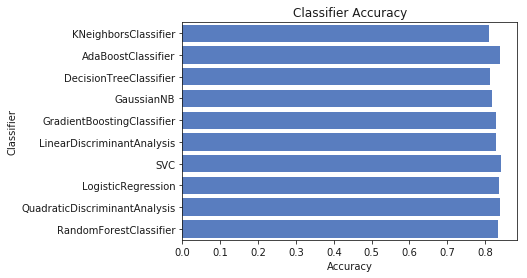

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train_v[0::, 1::]
y = train_v[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        if name in acc_dict:
            acc_dict[name] += acc
        else:
            acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

##### Logistic Regression

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.78


In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[128  29]
 [ 30  80]]


The result is telling us that we have 128+80 correct predictions and 29+30 incorrect predictions.

Next I computed precision, recall, F-measure and support:

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_test.

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.81      0.82      0.81       157
        1.0       0.73      0.73      0.73       110

avg / total       0.78      0.78      0.78       267



ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

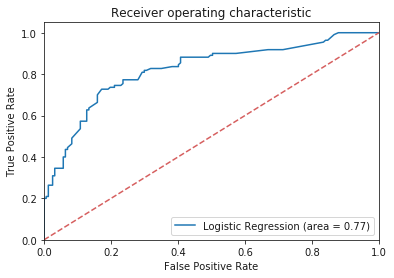

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Since the accuracy of the model could vary depending on which rows were selected for the training and test sets. We will get around this problem by using a shuffle validator.

In [28]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)
logreg.fit (X_train, y_train)
logreg.score (X_test, y_test)
shuffle_validator = cross_validation.ShuffleSplit(len(X), n_iter=30, test_size=0.2, random_state=0)
scores = cross_validation.cross_val_score(logreg, X, y, cv=shuffle_validator)
print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

Accuracy: 0.8129 (+/- 0.03)


The result shows that our decision tree classifier has an overall accuracy of 81.29%, although it can go up to 84% and down to 78% depending on the training/test split. 

##### Random Forest

In [30]:
# create param grid object 
forrest_params = dict(     
    max_depth = [n for n in range(9, 14)],     
    min_samples_split = [n for n in range(4, 11)], 
    min_samples_leaf = [n for n in range(2, 5)],     
    n_estimators = [n for n in range(10, 60, 10)],
)

Next, I instantiate the random forrest classifier:

In [31]:
# instantiate Random Forest model
forrest = RandomForestClassifier()

Lastly, I build the GridSearchCV and fit the model:

In [32]:
# build and fit model 
forest_cv = GridSearchCV(estimator=forrest, param_grid=forrest_params, cv=6) 
forest_cv.fit(X, y)

GridSearchCV(cv=6, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [2, 3, 4], 'min_samples_split': [4, 5, 6, 7, 8, 9, 10], 'n_estimators': [10, 20, 30, 40, 50], 'max_depth': [9, 10, 11, 12, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Using the best_score_ and best_estimator_ methods to retrieve the best score and the parameters that led to that score:

In [33]:
print("Best score: {}".format(forest_cv.best_score_))
print("Optimal params: {}".format(forest_cv.best_estimator_))

Best score: 0.8335208098987626
Optimal params: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [139]:
# random forrest prediction on test set
forrest_pred = forest_cv.predict(X_test)

In [140]:
forrest_pred

array([0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 0.])